# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

In [ ]:
**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [85]:
#importing some useful packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import fnmatch
import time
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


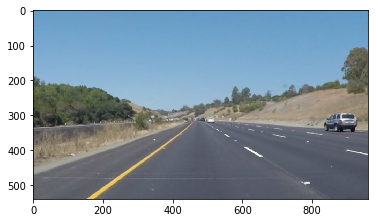

In [86]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [87]:
SHOW_DEBUG_IMAGES = False
SAVE_PIPELINE_IMAGES = False
left_slope_history = []
left_intercept_history = []
right_slope_history = []
right_intercept_history = []


def save_history(left, right):
    if left is not None:
        left_slope_history.append(left[0])
        left_intercept_history.append(left[1])
    if right is not None:
        right_slope_history.append(right[0])
        right_intercept_history.append(right[1])


def perform_lane_detection(path="test_videos/challenge.mp4"):
    video_cap = imageio.get_reader(path)
    for frame in video_cap:
        lanes_detection(frame)


def get_height_width(image):
    return image.shape[1], image.shape[0], image.shape[0] * .65


def get_masked_image(image):
    # HSV image
    image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # gray-scale image
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # get region of image within yellow range
    mask_yellow = cv.inRange(image_hsv,
                             np.array([20, 100, 100]),  # yellow lower
                             np.array([100, 255, 255]))  # yellow upper

    # get region of image within white range
    mask_white = cv.inRange(image_hsv,
                            np.array([0, 0, 240]),  # white lower
                            np.array([255, 255, 255]))  # white lower

    # merge results of yellow and white - bitwise OR
    mask_hsv = cv.bitwise_or(mask_yellow, mask_white)
    # only retain the information of the lanes in the image - bitwise AND
    masked_image = cv.bitwise_and(image_gray, mask_hsv)
    return masked_image


def remove_image_noise(image, kernel=(3, 3)):
    filtered_image = cv.GaussianBlur(image,  # source
                                     kernel,  # kernel size
                                     0)  # border type
    return filtered_image


def get_edges(image, low, high):
    edges = cv.Canny(image,
                     low,  # low threshold
                     high)  # high threshold
    return edges


def get_masked_edges(width, height_bottom, height_top, edges, ignore_mask_color=255):
    # blank matrix
    mask = np.zeros_like(edges)
    # ROI vertices
    vertices = np.array([[(width * 0.05, height_bottom),  # left bottom
                          (width / 3., height_top),  # left top
                          (2 * width / 3., height_top),  # right top
                          (width * 0.95, height_bottom)]],  # right bottom
                        dtype=np.int32)
    # create ROI
    cv.fillPoly(mask,  # image
                vertices,  # coordinates
                ignore_mask_color)
    # remove the parts of image which are not within ROI - bitwise AND
    masked_edges = cv.bitwise_and(edges, mask)
    return masked_edges


def get_hough_lines(image, rho=2, theta=1, voting=25,
                    min_line_length=20, max_line_gap=1):
    return cv.HoughLinesP(image,  # source
                          rho,
                          theta * np.pi / 180,  # degree to radian
                          voting,  # minimum voting in hough accumulator
                          min_line_length,  # min line length in pixels
                          max_line_gap  # gap b/w lines in pixels
                          )


def get_weighted_lanes(detected_lines):
    # hough line transform provides several detected lines
    # we want to reduce all the to just 2 lines
    # lines will be weighted w.r.t the length of the lines
    # resultant lines are called lanes (left and right)
    right_slope_intercept = []
    right_length = []
    left_slope_intercept = []
    left_length = []
    for line in detected_lines:
        # get start and end coordinates of each line
        for x1, y1, x2, y2 in line:
            # ignore same coordinate to avoid infinite slope
            if x1 == x2:
                continue
            # slope of line
            line_slope = float(y2 - y1) / float(x2 - x1)
            # angle of deviation
            line_angle = np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi
            # y intercept
            line_intercept = y1 - line_slope * x1
            # line length, used for weight
            line_length = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
            # in openCV, image is a matrix
            # bottom y values are higher than top y values
            # it means slope is negative for left line
            # left slope = delta_y --> -ve, delta_x --> +ve
            # right slope = delta_y --> -ve, delta_x --> -ve
            if line_slope < 0:
                left_slope_intercept.append((line_slope, line_intercept))
                left_length.append(line_length)
            elif line_slope > 0:
                right_slope_intercept.append((line_slope, line_intercept))
                right_length.append(line_length)

    # weighted mean
    # https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
    # simple arithmetic mean doesn't take into account the ...
    # ...significance of individual lines, which causes fluctuation & noise
    # length of each line can be used as a weight
    # weight average --> (sum of product) / (sum of weight)
    # sop --> sum of product
    sop_left = np.dot(left_length, left_slope_intercept)
    sop_right = np.dot(right_length, right_slope_intercept)
    left_weight = np.sum(left_length)
    right_weight = np.sum(right_length)
    # handling cases when no line is detected by hough transform
    left_bound = len(left_length) > 0 and sop_left[0] < -0.5
    right_bound = len(right_length) > 0 and sop_right[0] > 0.5

    left = (sop_left / left_weight) if left_bound else None
    right = (sop_right / right_weight) if right_bound else None
    save_history(left, right)
    # resultant is 2 lanes out of several hough lines
    return left, right


def get_coordinates(height_bottom, height_top, left, right):
    # there are cases when no no line is detected by hough
    # in that case we can use the history of slope and intercept
    # and get the average values from the history
    # but since lane might be changing between the frames
    # so just get average of last 10 values
    if left is None:
        left = [np.mean(left_slope_history[-10:]),
                np.mean(left_intercept_history[-10:])]
    if right is None:
        right = [np.mean(right_slope_history[-10:]),
                 np.mean(right_intercept_history[-10:])]

    # start and end x coordinates for the lane
    # x --> (y - intercept) / slope
    slope, intercept = left
    x_l1 = int((height_bottom - intercept) / slope)
    x_l2 = int((height_top - intercept) / slope)

    slope, intercept = right
    x_r1 = int((height_bottom - intercept) / slope)
    x_r2 = int((height_top - intercept) / slope)
    # y coordinates
    y1 = int(height_bottom)
    y2 = int(height_top)
    return ((x_l1, y1), (x_l2, y2)), ((x_r1, y1), (x_r2, y2))


def draw_hough_lines(edges, lines, color=(255, 0, 0), thickness=5):
    # creating a blank to draw lines on
    lane_image = np.zeros((edges.shape[0],  # --> height
                           edges.shape[1],  # --> width
                           3),
                          dtype=np.uint8)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv.line(lane_image,  # source
                    (x1, y1),  # (x1, y1)
                    (x2, y2),  # (x2, y2)
                    color,  # BGR color --> red
                    thickness  # line thickness
                    )
    plt.imshow(lane_image)
    return lane_image


def draw_weighted_lanes(edges, left_coordinates, right_coordinates,
                        color=(255, 0, 0), thickness=5):
    # creating a blank to draw lines on
    lane_image = np.zeros((edges.shape[0],  # --> height
                           edges.shape[1],  # --> width
                           3),
                          dtype=np.uint8)
    for coordinates in (left_coordinates, right_coordinates):
        start_coordinate, end_coordinate = coordinates
        cv.line(lane_image,  # source
                start_coordinate,  # (x1, y1)
                end_coordinate,  # (x2, y2)
                color,  # RGB color --> red
                thickness  # line thickness
                )
    return lane_image


def get_resultant_image(source1, source2, alpha=0.8, beta=1, gamma=0):
    resultant = cv.addWeighted(source1,
                               alpha,  # weight of the first array elements
                               source2,  # source 2
                               beta,  # weight of the second array elements
                               gamma)  # scalar added to each sum
    return resultant

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [88]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

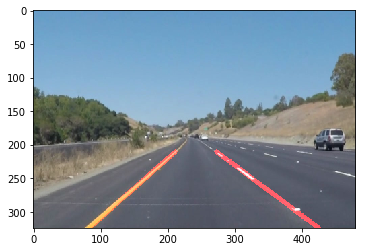

In [89]:
image = cv.resize(image, None, fx=0.5, fy=0.6, interpolation=cv.INTER_LINEAR)
# STEP - 1: get the width and height of image
width, height_bottom, height_top = get_height_width(image)  # STEP - 2: get the white and yellow lanes from the image
masked_image = get_masked_image(image)
# STEP - 3: remove noise using gaussian filter with 9x9 kernel size
filtered_image = remove_image_noise(masked_image, kernel=(9, 9))
# STEP - 4: get canny edge
edges = get_edges(filtered_image, low=50, high=150)
# STEP - 5: remove edges outside of ROI
masked_edges = get_masked_edges(width, height_bottom, height_top, edges)
# STEP - 6: find lines using hough
hough_lines = get_hough_lines(masked_edges)
# STEP - 7: get left and right lanes from several hough lines
left_lane, right_lane = get_weighted_lanes(hough_lines)
# STEP - 8: get the coordinates of the left and right lanes
left_coordinates, right_coordinates = get_coordinates(height_bottom, height_top, left_lane, right_lane)
# STEP - 9: draw lanes on a blank image
lane_image = draw_weighted_lanes(masked_edges, left_coordinates, right_coordinates)
# STEP - 10: draw lanes on original image
weighted_image = get_resultant_image(lane_image, image)
plt.imshow(weighted_image)
plt.show()

In [90]:
## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

SyntaxError: invalid syntax (<ipython-input-90-5d02ab88d3d7>, line 3)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [91]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # STEP - 0: resize frame to better visualize
    image = cv.resize(image, None, fx=0.5, fy=0.6, interpolation=cv.INTER_LINEAR)
    # STEP - 1: get the width and height of image
    width, height_bottom, height_top = get_height_width(image)
    # STEP - 2: get the white and yellow lanes from the image
    masked_image = get_masked_image(image)
    # STEP - 3: remove noise using gaussian filter with 9x9 kernel size
    filtered_image = remove_image_noise(masked_image, kernel=(9, 9))
    # STEP - 4: get canny edge
    edges = get_edges(filtered_image, low=50, high=150)
    # STEP - 5: remove edges outside of ROI
    masked_edges = get_masked_edges(width, height_bottom, height_top, edges)
    # STEP - 6: find lines using hough
    hough_lines = get_hough_lines(masked_edges)
    # STEP - 7: get left and right lanes from several hough lines
    left_lane, right_lane = get_weighted_lanes(hough_lines)
    # STEP - 8: get the coordinates of the left and right lanes
    left_coordinates, right_coordinates = get_coordinates(height_bottom, height_top, left_lane, right_lane)
    # STEP - 9: draw lanes on a blank image
    lane_image = draw_weighted_lanes(masked_edges, left_coordinates, right_coordinates)
    # STEP - 10: draw lanes on original image
    weighted_image = get_resultant_image(lane_image, image)
    # save_input_image(weighted_image, "hough", "result_images/")
    return weighted_image

Let's try the one with the solid white lane on the right first ...

In [92]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 84.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.12 s, sys: 274 ms, total: 2.4 s
Wall time: 2.86 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [94]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:08<00:00, 83.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.35 s, sys: 827 ms, total: 7.18 s
Wall time: 8.63 s


In [95]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [96]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:06<00:00, 31.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 4.4 s, sys: 757 ms, total: 5.16 s
Wall time: 7.46 s


In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))